In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDatasetEmbedding, UnpairedEmbeddingsDataset
from generators import  OneHotGenerator
from discriminators import MultiChannelDiscriminator 
import os
import glob
import generators

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config
PHASES = [1, 3]
UNPAIRED = True 
SKIPCONNECTIONS = True
EMBEDDING = True
if EMBEDDING == True:
    DOWN = False
    BOTTLENECK = True
ONEHOTENCODING = True

# LR scheduler
MultiStepLR = False
ReduceLROnPlateau = True

if MultiStepLR  == True and ReduceLROnPlateau == True:
    #raise error
    print("Error: Only one learning rate scheduler can be used at a time.")
    raise (NameError)
if MultiStepLR == False and ReduceLROnPlateau == False:
    print("Error: At least one learning rate scheduler must be used.")
    raise (NameError)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 1e-2 
NUM_WORKERS = 16
NUM_EPOCHS = 5

SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"  # RVtot_kalibriert existiert auch
source_signals = [SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256

GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample

# Use adversarial loss
GAN_LOSS = True   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = False 
LAMBDA_SUPERVISED = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

### Load all data and preprocess

Subsamplen, normalisieren pro Datei

In [3]:
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files" 
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = pd.DataFrame()
scaler = StandardScaler() 
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df_temp = pd.read_csv(f, sep=";")
    df_temp = utils.drop_cols(df_temp)
    df_temp = df_temp.dropna()
    df_temp = utils.remove_strings(df_temp)
    df_temp = utils.subsample(df_temp, 10)
    df_temp = utils.normalize(df_temp, scaler, phase1 = True)  
      
    # print the content
    df = pd.concat([df, df_temp], axis=0)
    

print(df.shape)

(6022044, 13)


In [4]:
# visualize the data
# utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung', 'animal'], 500)

### Select part of data to use in experiment

In [5]:
# select which phases to use
df = df.loc[df['Phasenzuordnung'].isin(PHASES)]
print('Size of the dataset after selecting Phasenzuordnung 1',df.shape)

print('Size of the dataset with data from phase 1',df.shape)
print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)

Size of the dataset after selecting Phasenzuordnung 1 (2122212, 13)
Size of the dataset with data from phase 1 (2122212, 13)
Size of Phase 1:  (751120, 13)
Size of Phase 2:  (0, 13)
Size of Phase 3:  (1371092, 13)
Size of Phase 4:  (0, 13)
SIze of Phase 5:  (0, 13)


In [6]:
# get unique interventions in df
df['intervention'].unique()

array([ 1.,  3., 10.,  2.,  4.])

In [7]:
# in Phase 1 nothing happens -> intervention information is not useful
for index, row in df.iterrows():
    if row['Phasenzuordnung'] == 1:
        # change the intervention to 11
        df.at[index, 'intervention'] = 6
    if row['intervention'] == 10:
        # change the intervention to 5
        df.at[index, 'intervention'] = 5
        

# get unique interventions in df
df['intervention'].unique()

array([6., 5.])

In [8]:
df.head()

,LVtot_kalibriert,LVP,AoP,AoQ,RVtot_kalibriert,VADspeed,VadQ,VADcurrent,LVtot,RVtot,intervention,Phasenzuordnung,animal
0,1.188663,-0.802621,0.494975,-0.441034,0.500008,0.897614,-0.810537,-0.561593,1.188662,0.500008,6.0,1,8
1,1.240719,-0.807301,0.470217,-0.565181,0.554155,-0.923932,-0.903626,-0.666560,1.240720,0.554155,6.0,1,8
2,1.294211,-0.812848,0.450666,-0.517859,0.604946,0.573059,-0.899748,-0.933307,1.294211,0.604946,6.0,1,8
3,1.343949,-0.812742,0.422694,-0.359808,0.648758,-0.846622,-0.989590,-1.114400,1.343948,0.648758,6.0,1,8
4,1.381228,-0.806822,0.354014,-0.295511,0.690322,0.538466,-1.053549,-1.026302,1.381229,0.690322,6.0,1,8


### Drop animals with less than 10 data points
We drop animals from the dataframe, if they have less than 10 data points. Initially, we have 56 animals and after dropping those with close to no data points, we are left with 25 animals

In [9]:
print(len(df['animal'].unique()))
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('Number of animals after removing those with less than 10 data points: ', len(df['animal'].unique()))

# get all differnent animals
animals = df['animal'].unique()
print(animals)

25
Number of animals after removing those with less than 10 data points:  25
[  8  12  13 108   7  14  11   2  16  10 105 111  17  19   3  15   5  20
 113   4 102   1   9 107 101]


### Split data into train and test split

The 5 test animals represent 20.20924% of the whole data. If we don't use all phases, this number might be different

In [10]:
# select animals 2,3, 7, 10 and 16 as test animals
test_animals = [3,4,8,11,17] # 3,4,8,11,17
print('\nTest animal(s):', test_animals)

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

# test data
df_test = df[df['animal'].isin(test_animals)]

# change the length of the test data to a multiple of the Window size
df_test = df_test.iloc[:len(df_test) - (len(df_test) % WINDOW)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [3, 4, 8, 11, 17]

Different animal IDs after removing those that are in the test dataset:  20

Train data shape: (1506963, 13)

Test data shape: (615168, 13)

The test dataset is 28.98821986013116 percent of the whole data: 


#### Initialize Generator and Discriminator

We also initialize the 2 optimizers, the 2 Learning rate schedulers, the losses

In [11]:
import torch.nn.functional as F

def double_conv_pad(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        nn.BatchNorm1d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Dropout1d(p=0.1, inplace=False),
        nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        nn.BatchNorm1d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Dropout1d(p=0.1, inplace=False),
    )

class SkipTensorEmbeddingGen(nn.Module):
    def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS, Down = True, Bottleneck = True):
        super(SkipTensorEmbeddingGen, self).__init__()
        self.Down = Down
        self.Bottleneck = Bottleneck
        self.maxpool = nn.MaxPool1d((2))  

        self.source_intervention = torch.nn.Embedding(num_embeddings=11, embedding_dim=256)
        self.source_phase = torch.nn.Embedding(num_embeddings=6, embedding_dim=256)

        self.down_conv1 = double_conv_pad(INPUTCHANNELS, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.target_intervention = torch.nn.Embedding(num_embeddings=11, embedding_dim=32)
        self.target_phase = torch.nn.Embedding(num_embeddings=6, embedding_dim=32)

        self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
        self.up_conv1 = double_conv_pad(256, 128)
        self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
        self.up_conv2 = double_conv_pad(128, 64)
        self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=(2), stride=2, padding=0)
        self.up_conv3 = double_conv_pad(64, 32)

        self.out = nn.Conv1d(32, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Conv1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.ConvTranspose1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=1)
        elif isinstance(module, nn.BatchNorm1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, input, source_phase, source_intervention, target_phase, target_intervention):
        if self.Down:
            sp = self.source_phase(source_phase)
            si = self.source_intervention(source_intervention)
            input += sp + si 
        x1 = self.down_conv1(input) 
        x2 = self.maxpool(x1) 
        x3 = self.down_conv2(x2)
        x4 = self.maxpool(x3) 
        x5 = self.down_conv3(x4) 
        x6 = self.maxpool(x5)  
        x7 = self.down_conv4(x6)

        # # decoder
        if self.Bottleneck:
            tp = self.target_phase(target_phase)  
            ti = self.target_intervention(target_intervention)
            x7 += tp + ti # target embeddings are added before upsampling  # lieber concatenating und dann fully connected to amtch the dimension
        x = self.up_trans1(x7)
        x = self.up_conv1(torch.cat([x, x5], 1))
        x = self.up_trans2(x)
        x = self.up_conv2(torch.cat([x, x3], 1))
        x = self.up_trans3(x)
        x = self.up_conv3(torch.cat([x, x1], 1))
        x = self.out(x)

        return x

In [12]:
class TensorEmbeddingGen(nn.Module):
    def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS, Down = True, Bottleneck = True):
        super(TensorEmbeddingGen, self).__init__()
        self.Down = Down
        self.Bottleneck = Bottleneck
        self.maxpool = nn.MaxPool1d((2))  

        self.source_intervention = torch.nn.Embedding(num_embeddings=11, embedding_dim=256)
        self.source_phase = torch.nn.Embedding(num_embeddings=6, embedding_dim=256)

        self.down_conv1 = double_conv_pad(INPUTCHANNELS, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.target_intervention = torch.nn.Embedding(num_embeddings=11, embedding_dim=32)
        self.target_phase = torch.nn.Embedding(num_embeddings=6, embedding_dim=32)

        self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
        self.up_conv1 = double_conv_pad(128, 128)
        self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
        self.up_conv2 = double_conv_pad(64, 64)
        self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=(2), stride=2, padding=0)
        self.up_conv3 = double_conv_pad(32, 32)

        self.out = nn.Conv1d(32, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Conv1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.ConvTranspose1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=1)
        elif isinstance(module, nn.BatchNorm1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, input, source_phase, source_intervention, target_phase, target_intervention):
        if self.Down:
            sp = self.source_phase(source_phase)
            si = self.source_intervention(source_intervention)
            input += sp + si 
        x1 = self.down_conv1(input) 
        x2 = self.maxpool(x1) 
        x3 = self.down_conv2(x2)
        x4 = self.maxpool(x3) 
        x5 = self.down_conv3(x4) 
        x6 = self.maxpool(x5)  
        x7 = self.down_conv4(x6)

        # # decoder
        if self.Bottleneck:
            tp = self.target_phase(target_phase)  
            ti = self.target_intervention(target_intervention)
            x7 += tp + ti # target embeddings are added before upsampling  # lieber concatenating und dann fully connected to amtch the dimension
        x = self.up_trans1(x7)
        x = self.up_conv1(x)
        x = self.up_trans2(x)
        x = self.up_conv2(x)
        x = self.up_trans3(x)
        x = self.up_conv3(x)
        x = self.out(x)

        return x

In [23]:
class OneHotGenerator(nn.Module):
    def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS, WINDOWSIZE, Down = True, Bottleneck = True):
        super(OneHotGenerator, self).__init__()
        self.WINDOWSIZE = WINDOWSIZE
        self.Down = Down
        self.Bottleneck = Bottleneck
        self.maxpool = nn.MaxPool1d((2))  

        self.sourcephaseLinear = nn.Linear(7, 1)
        self.sourceinterventionLinear = nn.Linear(7, 1)
        self.sourceFCLinear = nn.Linear(768, 256)

        self.down_conv1 = double_conv_pad(INPUTCHANNELS, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.targetphaseLinear = nn.Linear(7, 32)
        self.targetinterventionLinear = nn.Linear(7, 32)
        self.targetFCLinear = nn.Linear(96, 32)

        self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
        self.up_conv1 = double_conv_pad(256, 128)
        self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
        self.up_conv2 = double_conv_pad(128, 64)
        self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=(2), stride=2, padding=0)
        self.up_conv3 = double_conv_pad(64, 32)

        self.out = nn.Conv1d(32, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Conv1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.ConvTranspose1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=1)
        elif isinstance(module, nn.BatchNorm1d):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()


    def forward(self, input, source_phase, source_intervention, target_phase, target_intervention):
        # downsampling
        if self.Down:
            pS = F.one_hot(source_phase, num_classes=7).type(torch.FloatTensor).to(DEVICE)  #torch.Size([1, 256, 6])
            iS = F.one_hot(source_intervention, num_classes=7).type(torch.FloatTensor).to(DEVICE) #torch.Size([1, 256, 11])
            pS = self.sourcephaseLinear(pS).to(DEVICE)
            iS = self.sourceinterventionLinear(iS).to(DEVICE)
            pS = pS.reshape(input.shape[0], input.shape[1], input.shape[2]).to(DEVICE)
            iS = iS.reshape(input.shape[0], input.shape[1], input.shape[2]).to(DEVICE)
            # Concatenate the phase and intervention one hot encodings with the output of the last convolutional layer and reshape
            input = torch.cat([input, pS, iS], 2) # torch.Size([1, 1, 768])\
            input = self.sourceFCLinear(input).to(DEVICE) 

        x1 = self.down_conv1(input)   
        x2 = self.maxpool(x1) 
        x3 = self.down_conv2(x2)  
        x4 = self.maxpool(x3) 
        x5 = self.down_conv3(x4) 
        x6 = self.maxpool(x5) 
        x7 = self.down_conv4(x6)     

        # upsampling
        if self.Bottleneck:
            # one hot encoding
            pT = F.one_hot(target_phase, num_classes=7).type(torch.FloatTensor).to(DEVICE)
            iT = F.one_hot(target_intervention, num_classes=7).type(torch.FloatTensor).to(DEVICE)
            # Fully connected Layers
            pT = self.targetphaseLinear(pT).to(DEVICE)
            iT = self.targetinterventionLinear(iT).to(DEVICE)
            # Concatenate the phase and intervention one hot encodings with the output of the last convolutional layer and reshape
            x7 = torch.cat([x7, pT, iT], 1) 
            x7 = x7.reshape(x7.shape[0], self.WINDOWSIZE, 96)
            x7 = self.targetFCLinear(x7).to(DEVICE) 
        
        x = self.up_trans1(x7)
        x = self.up_conv1(torch.cat([x, x5], 1))  # skip connection
        x = self.up_trans2(x)
        x = self.up_conv2(torch.cat([x, x3], 1))  # skip connection
        x = self.up_trans3(x)
        x = self.up_conv3(torch.cat([x, x1], 1))  # skip connection
        x = self.out(x)
        return x

In [24]:
# import torch.nn.functional as F

# def double_conv_pad(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.BatchNorm1d(out_channels),
#         nn.LeakyReLU(inplace=True),
#         nn.Dropout1d(p=0.1, inplace=False),
#         nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.BatchNorm1d(out_channels),
#         nn.LeakyReLU(inplace=True),
#         nn.Dropout1d(p=0.1, inplace=False),
#     )

# class OneHotGenerator(nn.Module):
#     def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS, WINDOWSIZE, Down = True, Bottleneck = True):
#         super(OneHotGenerator, self).__init__()
#         self.WINDOWSIZE = WINDOWSIZE
#         self.Down = Down
#         self.Bottleneck = Bottleneck
#         self.maxpool = nn.MaxPool1d((2))  

#         self.down_conv1 = double_conv_pad(INPUTCHANNELS, 32) 
#         self.down_conv2 = double_conv_pad(32, 64) 
#         self.down_conv3 = double_conv_pad(64, 128)
#         self.down_conv4 = double_conv_pad(128, 256)
#         # self.down_conv5 = double_conv_pad(256, 512)
#         # self.down_conv6 = double_conv_pad(512, 1024)
        
#         self.sourcephaseLinear = nn.Linear(6, 1)
#         self.sourceinterventionLinear = nn.Linear(11, 1)
#         self.sourceFCLinear = nn.Linear(768, 256)

#         self.targetphaseLinear = nn.Linear(6, 32)
#         self.targetinterventionLinear = nn.Linear(11, 32)
#         self.targetFCLinear = nn.Linear(96, 32)

#         # self.up_trans1 = nn.ConvTranspose1d(1024, 512, kernel_size=(2), stride=2, padding=0)
#         # self.up_conv1 = double_conv_pad(1024, 512)
#         # self.up_trans2 = nn.ConvTranspose1d(512, 256, kernel_size=(2), stride=2, padding=0)
#         # self.up_conv2 = double_conv_pad(512, 256)
#         self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
#         self.up_conv1 = double_conv_pad(256, 128)
#         self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
#         self.up_conv2 = double_conv_pad(128, 64)
#         self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=(2), stride=2, padding=0)
#         self.up_conv3 = double_conv_pad(64, 32)

#         self.out = nn.Conv1d(32, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

#         self.apply(self._init_weights)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Conv1d):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.ConvTranspose1d):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=1)
#         elif isinstance(module, nn.BatchNorm1d):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()


#     def forward(self, input, source_phase, source_intervention, target_phase, target_intervention):
#         # downsampling
#         if self.Down:
#             pS = F.one_hot(source_phase, num_classes=6).type(torch.FloatTensor).to(DEVICE)  #torch.Size([1, 256, 6])
#             iS = F.one_hot(source_intervention, num_classes=11).type(torch.FloatTensor).to(DEVICE) #torch.Size([1, 256, 11])
#             pS = self.sourcephaseLinear(pS)
#             iS = self.sourceinterventionLinear(iS)
#             pS = pS.reshape(pS.shape[0], pS.shape[2], pS.shape[1])
#             iS = iS.reshape(iS.shape[0], iS.shape[2], iS.shape[1])
#             # Fully connected Layers
#             # input shape torch.Size([1, 1, 256])
#             # reshape pS to torch.Size([1, 256, 1])
#             # pS = self.sourcephaseLinear(pS)
#             # iS = self.sourceinterventionLinear(iS)
#             # pS = pS.reshape(input.shape[0], input.shape[1], input.shape[2]).to(DEVICE)
#             # iS = iS.reshape(input.shape[0], input.shape[1], input.shape[2]).to(DEVICE)
#             # Concatenate the phase and intervention one hot encodings with the output of the last convolutional layer and reshape
#             input = torch.cat([input, pS, iS], 2) # torch.Size([1, 1, 768])\
#             # input = input.reshape(input.shape[0], self.WINDOWSIZE, 96)
#             input = self.sourceFCLinear(input).to(DEVICE) 

#         x1 = self.down_conv1(input)   
#         x2 = self.maxpool(x1) 
#         x3 = self.down_conv2(x2)  
#         x4 = self.maxpool(x3) 
#         x5 = self.down_conv3(x4) 
#         x6 = self.maxpool(x5) 
#         x7 = self.down_conv4(x6)     

#         # upsampling
#         if self.Bottleneck:
#             # one hot encoding
#             pT = F.one_hot(target_phase, num_classes=6).type(torch.FloatTensor).to(DEVICE)
#             iT = F.one_hot(target_intervention, num_classes=11).type(torch.FloatTensor).to(DEVICE)
#             # Fully connected Layers
#             pT = self.targetphaseLinear(pT).to(DEVICE)
#             iT = self.targetinterventionLinear(iT).to(DEVICE)
#             # Concatenate the phase and intervention one hot encodings with the output of the last convolutional layer and reshape
#             x7 = torch.cat([x7, pT, iT], 1) 
#             x7 = x7.reshape(x7.shape[0], self.WINDOWSIZE, 96)
#             x7 = self.targetFCLinear(x7).to(DEVICE) 
        
#         x = self.up_trans1(x7)
#         x = self.up_conv1(torch.cat([x, x5], 1))  # skip connection
#         x = self.up_trans2(x)
#         x = self.up_conv2(torch.cat([x, x3], 1))  # skip connection
#         x = self.up_trans3(x)
#         x = self.up_conv3(torch.cat([x, x1], 1))  # skip connection
#         x = self.out(x)
#         return x

In [25]:
# Generator
if ONEHOTENCODING and SKIPCONNECTIONS:
    gen_target = OneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = OneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if not ONEHOTENCODING and SKIPCONNECTIONS:
    gen_target = SkipTensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = SkipTensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if not ONEHOTENCODING and not SKIPCONNECTIONS:
    gen_target = TensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    gen_source = TensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

# Discriminator
disc_target = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)
disc_source = MultiChannelDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# Optimizers 
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# Scheduler
if ReduceLROnPlateau:
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen,
                                                           factor=0.1, patience=3, threshold=1e-4,
                                                           min_lr=1e-6,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc,
                                                            factor=0.1, patience=3, threshold=1e-4,
                                                            min_lr=1e-6,
                                                    )
if MultiStepLR:
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_gen, milestones=[5,6,7,8], gamma=0.1)
                                                        
    disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_disc, milestones=[5,6,7,8], gamma=0.1)

# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss() 

#### Create the dataset and DataLoader

In [26]:
if UNPAIRED and EMBEDDING:
    # create dataset with information of the phases and intervention (embedding information)
    train_dataset = UnpairedEmbeddingsDataset(df_train, source_signals, target_name = TARGET, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)

if not UNPAIRED and EMBEDDING:
    train_dataset = AnimalDatasetEmbedding(df_train, source_signals, target_name = TARGET, test = False, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, test = True, window_length = WINDOW)


# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

#### Initialize weights and bias

In [27]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Cycle_GAN",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    }
)

In [28]:
def gen_signals(fake_target, fake_source, target, source):
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) / 2


# @torch.cuda.amp.autocast()
def get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    # generate fakes
    # with torch.no_grad():
    #     fake_B = gen_B(sig_A, phase, intervention).detach()
    #     fake_A = gen_A(sig_B, phase, intervention).detach()
    
    # discriminator loss
    disc_target_loss = discriminator_loss(disc_target, target, fake_target)
    disc_source_loss = discriminator_loss(disc_source, source, fake_source)
    disc_loss = (disc_source_loss + disc_target_loss) / 2

    return disc_loss, disc_source_loss, disc_target_loss

# @torch.cuda.amp.autocast()
def calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                  gen_source, gen_target, disc_source, disc_target, fake_target, fake_source
                  ):
    loss = 0

    if GAN_LOSS:
        g_source_loss = mse(disc_source(fake_source), torch.ones_like(disc_source(fake_source))) 
        g_target_loss = mse(disc_target(fake_target), torch.ones_like(disc_target(fake_target))) 

        loss += g_source_loss * LAMBDA_GAN + g_target_loss * LAMBDA_GAN
    else:
        g_source_loss = torch.tensor(0)
        g_target_loss = torch.tensor(0)

    if CYCLE:
        rec_target = gen_target(fake_source, source_phase, source_intervention, target_phase, target_intervention)
        rec_source = gen_source(fake_target, source_phase, source_intervention, target_phase, target_intervention)
        cycle_target_loss = l1(target, rec_target)  # l1 loss: Mean absolute error between each element in the input x and target y
        cycle_source_loss = l1(source, rec_source)  # l1 loss in cycle GAN paper

        loss += cycle_target_loss * LAMBDA_CYCLE + cycle_source_loss * LAMBDA_CYCLE
    else:
        cycle_target_loss = torch.tensor(0)
        cycle_source_loss = torch.tensor(0)

    if SUPERVISED:
        sup_source_loss = mse(source, fake_source)
        sup_target_loss = mse(target, fake_target)

        loss += sup_source_loss * LAMBDA_SUPERVISED + sup_target_loss * LAMBDA_SUPERVISED
    else:
        sup_source_loss = torch.tensor(0)
        sup_target_loss = torch.tensor(0)

    if IDENTITY:
        id_target_loss = l1(target, gen_target(target, source_phase, source_intervention, target_phase, target_intervention))
        id_source_loss = l1(source, gen_source(source, source_phase, source_intervention, target_phase, target_intervention))

        loss += id_target_loss * LAMBDA_IDENTITY + id_source_loss * LAMBDA_IDENTITY
    else:
        id_target_loss = torch.tensor(0)
        id_source_loss = torch.tensor(0)

    return loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

## Training

In [29]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target, source_phase, source_intervention, target_phase, target_intervention in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        source_phase = source_phase.to(DEVICE)
        source_intervention = source_intervention.to(DEVICE)
        target_phase = target_phase.to(DEVICE)
        target_intervention = target_intervention.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach()
            fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

        d_loss, disc_source_loss, disc_target_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                                                        # source, target, disc_source, disc_target, fake_source, fake_target

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_loss.backward()
        opt_disc.step()
        # d_scaler.scale(d_loss).backward()  
               

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                                gen_source, gen_target, disc_source, disc_target, fake_target, fake_source)
                            # source, target, source_phase, source_intervention, target_phase, target_intervention,
                            # gen_source, gen_target, disc_source, disc_target, fake_target, fake_source

        g_loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss = out
        # loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

        # update gradients of generator
        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()
        # g_scaler.scale(g_loss).backward()

    # Optimizer step
    # d_scaler.step(opt_disc)  
    # d_scaler.update()

    # g_scaler.step(opt_gen) 
    # g_scaler.update()

    wandb.log({'Train/Discriminator source loss': disc_source_loss.item(),
                'Train/Discriminator target loss': disc_target_loss.item(),
                'Train/Total Discriminator loss': d_loss.item(),
                'Train/Total Generator loss': g_loss.item(),
                'Train/Adversarial loss source': g_source_loss.item(),
                'Train/Adversarial loss target': g_target_loss.item(),
                'Train/Cycle consistency loss source': cycle_source_loss.item(),
                'Train/Cycle consistency loss target': cycle_target_loss.item(),
                'Train/Supervised loss source': sup_source_loss.item(),
                'Train/Supervised loss target': sup_target_loss.item(),
                'Learning rate': opt_gen.param_groups[0]["lr"],
                # 'Train/Identity loss A': id_A_loss.item(),
                # 'Train/Identity loss B': id_B_loss.item()
                })
        

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    if (epoch+1) % 5 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_source.eval()  # set discriminator to evaluation mode
            disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_target.eval()
            gen_source.eval()

            for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
                # convert to float16
                source = source.float()
                target = target.float()

                # move to GPU
                source = source.to(DEVICE)
                target = target.to(DEVICE)
                source_phase = source_phase.to(DEVICE)
                source_intervention = source_intervention.to(DEVICE)
                target_phase = target_phase.to(DEVICE)
                target_intervention = target_intervention.to(DEVICE)

                fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach() # already torch.no_grad()
                fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

                # generate signals during validation
                #gen_signals(fake_target, fake_source, target, source)

                # calculate l1 loss of fake signals and real signals
                test_real_fake_lossB= l1(target, fake_target)   # l1(sig_B, fake_B)
                test_real_fake_lossA = l1(source, fake_source)

                #  ------------------------------- #
                #  ----- test discriminators ----- #
                #  ------------------------------- #

                test_d_loss, test_disc_A_loss, test_disc_B_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                
                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                                gen_source, gen_target, disc_source, disc_target, 
                                fake_target, fake_source
                                )
                g_lossT, g_A_lossT, g_B_lossT, cycle_B_lossT, cycle_A_lossT, id_B_lossT, id_A_lossT, sup_A_lossT, sup_B_lossT = out
        
                # gen_signals(fake_target, fake_source, target, source)

            wandb.log({'Test/Generator loss': g_lossT.item(),
                        'Test/Discriminator loss': test_d_loss.item(),
                        'Test/L1 loss between real signal A and fake signals A': test_real_fake_lossA.item(),
                        'Test/L1 loss between real signal B and fake signals B': test_real_fake_lossB.item(),
                        'Test/Discriminator A loss': test_disc_A_loss.item(),
                        'Test/Discriminator B loss': test_disc_B_loss.item(),
                        'Test/Adversarial or GAN loss A': g_A_lossT.item(),
                        'Test/Adversarial or GAN loss B': g_B_lossT.item(),
                        'Test/Cycle consistency loss A': cycle_A_lossT.item(),
                        'Test/Cycle consistency loss B': cycle_B_lossT.item(),
                        'Test/Supervised loss A': sup_A_lossT.item(),
                        'Test/Supervised loss B': sup_B_lossT.item(),
                        'Test/Epoch': epoch+1,
                })
            
            
      
    disc_scheduler.step(d_loss)
    gen_scheduler.step(g_loss)

    

100%|██████████| 5/5 [23:27<00:00, 281.59s/it]


### Get losses of the training run

In [30]:
source_losses = []
target_losses = []
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 1.3726634221772354
Average L1 loss of target signals: 1.2197750488544503
Min and max loss of source signals: (0.4509595036506653, 2.3475759029388428)
Min and max loss of target signals: (0.47123223543167114, 2.2110841274261475)
Median loss of source signals: 1.383649468421936
Median loss of target signals: 1.2008002400398254


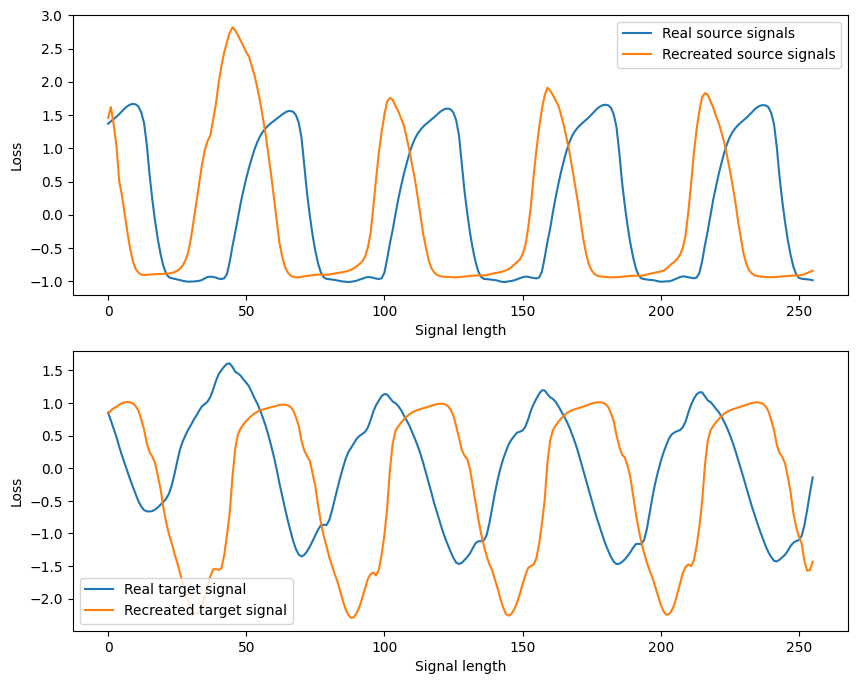

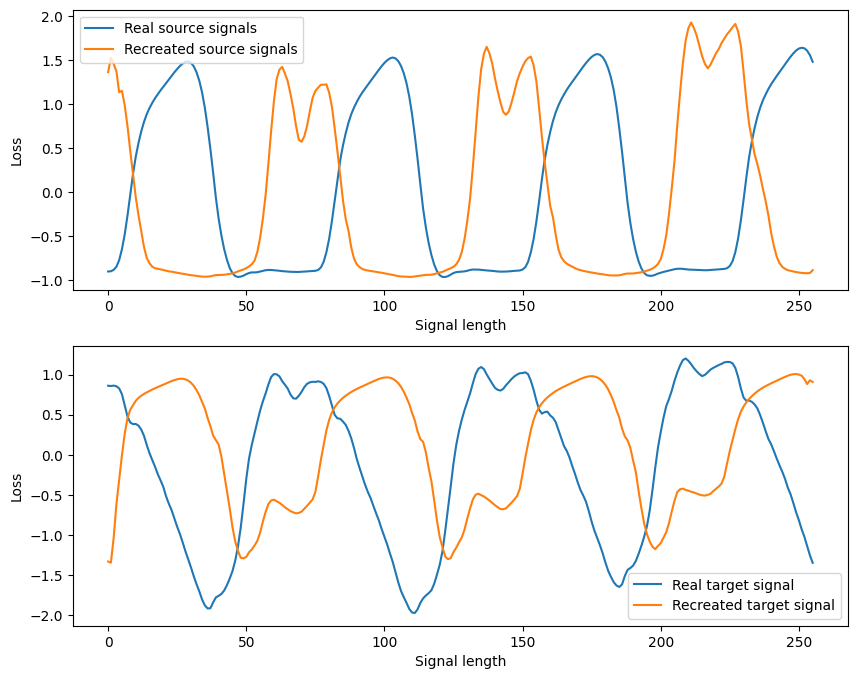

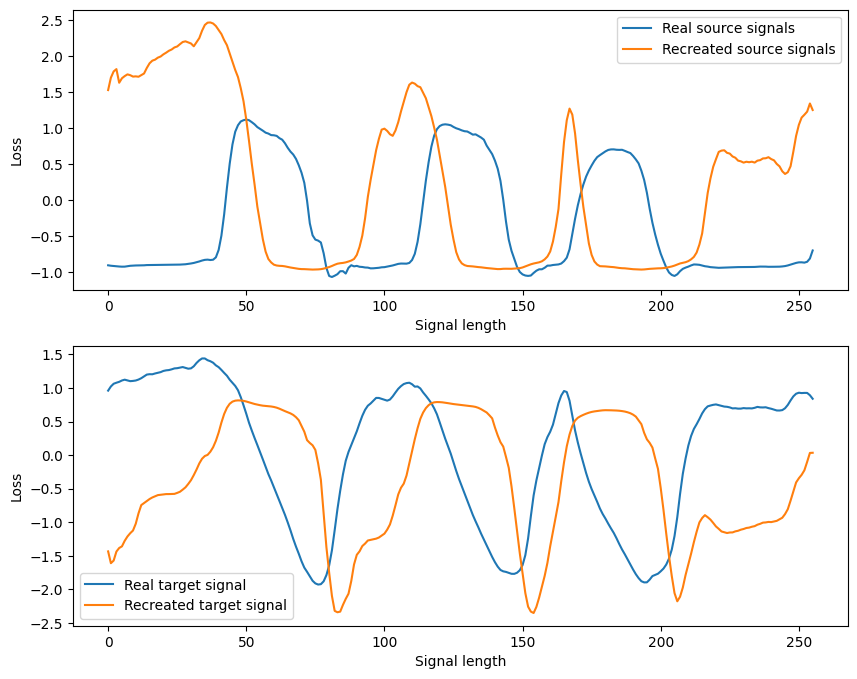

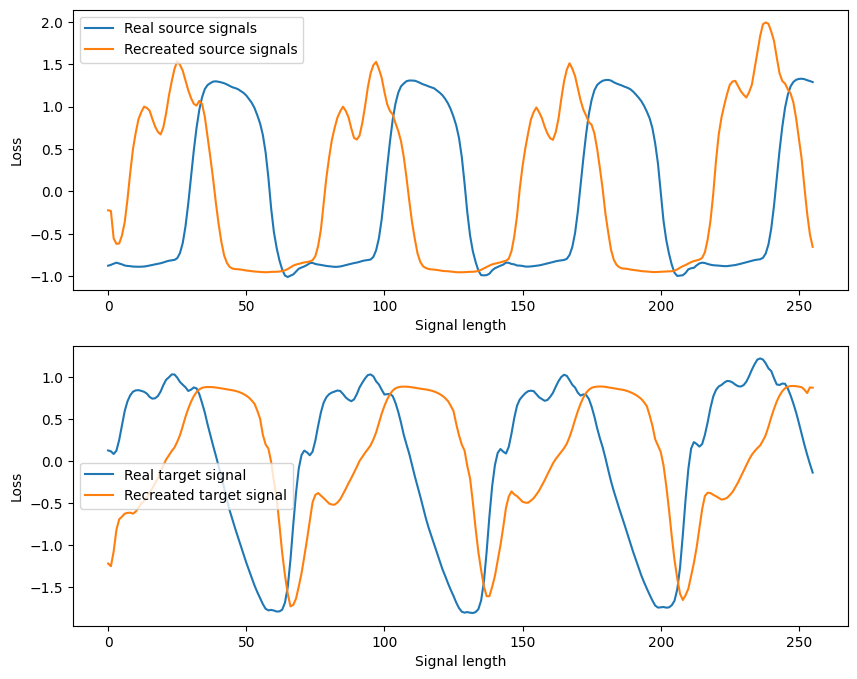

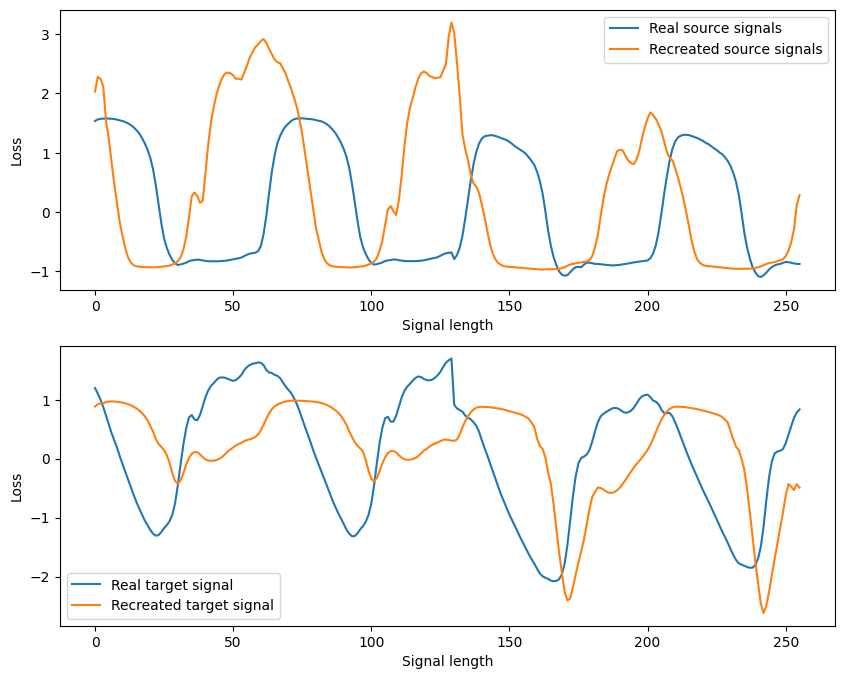

In [31]:
# Generate signals
idx = 0             
phases = df['Phasenzuordnung'].unique()
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
    if idx == 5:
        break                 
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)

                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1       